<a href="https://colab.research.google.com/github/MGentieu/Data_analytics_aircraft_messages/blob/main/Projet/GENTIEU_GOUESSE_Projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GENTIEU Martin et GOUESSE Sixtine : Projet de data analytics


## Détection des anomalies de trajectoire

### Etape 1 : Préparation de l'environnement

Installation du projet : Sur Google Colab :
Allez dans le terminal et exécutez :
```bash
git clone https://github.com/MGentieu/Data_analytics_aircraft_messages.git
```

###On se place dans un premier temps dans le répertoire parent

In [1]:
import os
import sys
from pathlib import Path

# Detect working directory
cwd = Path.cwd().resolve()

# If in Colab (/content), search for repo folder automatically
if cwd.name == "content":
    # Look for the cloned project automatically
    candidates = [d for d in cwd.iterdir() if d.is_dir() and "aircraft" in d.name.lower()]

    if not candidates:
        raise FileNotFoundError(
            f"Aucun dossier contenant 'aircraft' trouvé dans /content.\n"
            f"Dossiers présents : {os.listdir(cwd)}"
        )

    PROJECT_ROOT = candidates[0]/"Projet"
else:
    PROJECT_ROOT = cwd

print(f"Detected project root: {PROJECT_ROOT}")

# Validate directory
if not PROJECT_ROOT.exists():
    raise FileNotFoundError(f"Missing directory at {PROJECT_ROOT}")

# Add to Python path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Setup complete.")


Detected project root: /content/Data_analytics_aircraft_messages/Projet
Setup complete.


On importe ensuite les bibliothèques nécessaires à l'analyse :

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import folium
import shapely
import socket
import glob
import csv
from datetime import datetime
import random

On charge ensuite notre dataset et on fait une analyse primaire

In [6]:
df = pd.read_csv(f"{PROJECT_ROOT}/dataset_trajectoires_anomalies.csv")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13500 entries, 0 to 13499
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   flight_id       13500 non-null  object 
 1   anomaly_type    13500 non-null  object 
 2   timestamp       13500 non-null  object 
 3   latitude        13500 non-null  float64
 4   longitude       13500 non-null  float64
 5   altitude        13500 non-null  float64
 6   ground_speed    13500 non-null  int64  
 7   vertical_speed  13500 non-null  int64  
 8   heading         13500 non-null  int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 949.3+ KB


In [8]:
df.describe()

,latitude,longitude,altitude,ground_speed,vertical_speed,heading
count,13500.000000,13500.000000,13500.000000,13500.000000,13500.000000,13500.000000
mean,48.666662,3.323974,6583.362470,348.859778,5.775926,180.456667
std,1.318692,1.705202,2770.046721,87.076987,463.450880,104.743477
min,45.980001,1.900000,500.000000,200.000000,-800.000000,0.000000
25%,48.500000,2.251149,5515.100671,273.000000,-392.000000,89.000000
50%,48.895973,2.567975,7887.703525,348.000000,6.000000,181.000000
75%,49.500000,3.200000,8535.910858,425.000000,406.000000,271.000000
max,50.513801,7.020000,10058.716556,500.000000,800.000000,360.000000


In [9]:
df.head()

,flight_id,anomaly_type,timestamp,latitude,longitude,altitude,ground_speed,vertical_speed,heading
0,FLT0001,Normal,2025-01-01T12:00:00,48.504967,2.202505,7875.650748,385,-376,172
1,FLT0001,Normal,2025-01-01T12:00:20,48.512040,2.216887,7915.972844,392,644,54
2,FLT0001,Normal,2025-01-01T12:00:40,48.533323,2.220045,8112.094041,474,135,228
3,FLT0001,Normal,2025-01-01T12:01:00,48.555499,2.242591,8091.555540,485,-719,163
4,FLT0001,Normal,2025-01-01T12:01:20,48.551350,2.256622,7996.864761,393,763,159


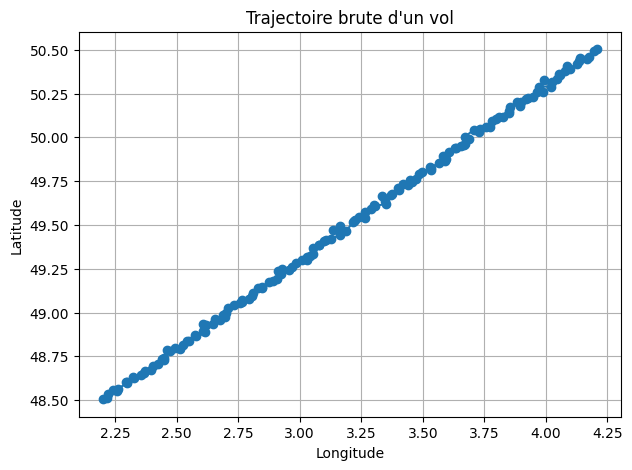

In [12]:
sample = df[df["flight_id"] == df["flight_id"].iloc[0]]

plt.figure(figsize=(7,5))
plt.plot(sample["longitude"], sample["latitude"], marker='o')
plt.title("Trajectoire brute d'un vol")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


In [17]:
df["anomaly_type"].unique()


array(['Normal', 'Hijacking_Suspected', 'Sharp_Turn_Diversion',
       'Emergency_Descent', 'Holding_Pattern', 'Glider_Thermal'],
      dtype=object)

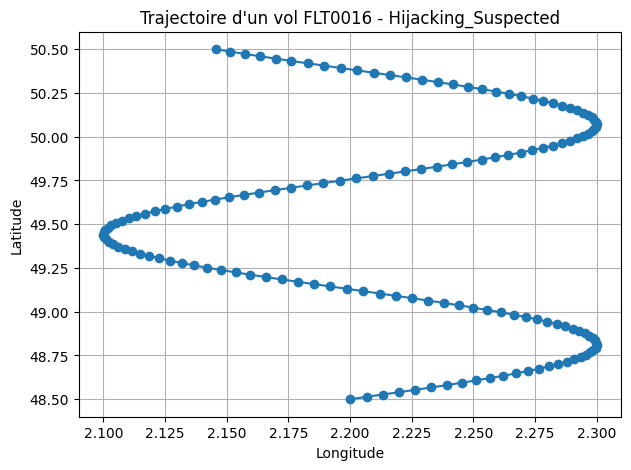

In [18]:
anomaly = "Hijacking_Suspected"

flight_id = df[df["anomaly_type"] == anomaly]["flight_id"].iloc[0]
sample = df[df["flight_id"] == flight_id]

plt.figure(figsize=(7,5))
plt.plot(sample["longitude"], sample["latitude"], marker='o')
plt.title(f"Trajectoire d'un vol {flight_id} - {anomaly}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

On choisit cette fois-ci une anoamlie aléatoire avec un vol aléatoire présentant cette anomalie.

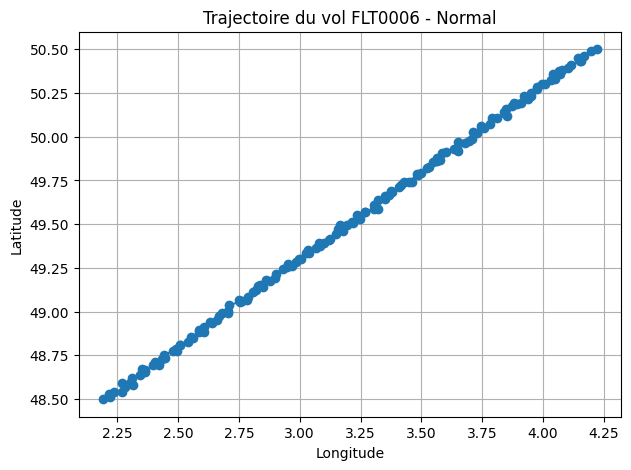

In [20]:
# 1. Sélectionner une anomalie aléatoire dans les valeurs existantes
anomaly = random.choice(df["anomaly_type"].unique())

# 2. Sélectionner un vol aléatoire contenant cette anomalie
flights_with_anomaly = df[df["anomaly_type"] == anomaly]["flight_id"].unique()
flight_id = random.choice(flights_with_anomaly)

# 3. Extraire les données du vol choisi
sample = df[df["flight_id"] == flight_id]

# 4. Plot
plt.figure(figsize=(7,5))
plt.plot(sample["longitude"], sample["latitude"], marker='o')
plt.title(f"Trajectoire du vol {flight_id} - {anomaly}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


2e tentative pour observer un résultat différent

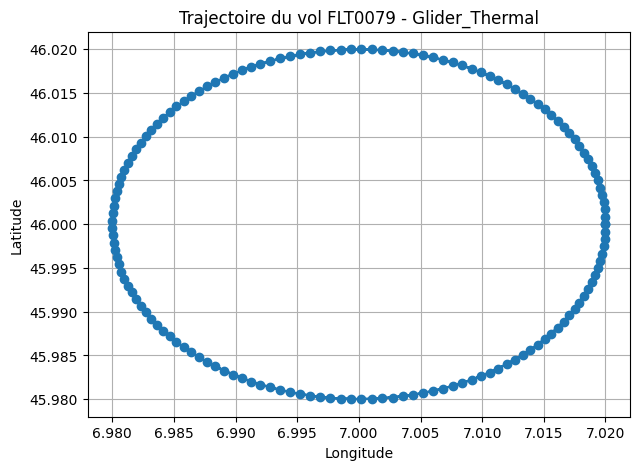

In [21]:
# 1. Sélectionner une anomalie aléatoire dans les valeurs existantes
anomaly = random.choice(df["anomaly_type"].unique())

# 2. Sélectionner un vol aléatoire contenant cette anomalie
flights_with_anomaly = df[df["anomaly_type"] == anomaly]["flight_id"].unique()
flight_id = random.choice(flights_with_anomaly)

# 3. Extraire les données du vol choisi
sample = df[df["flight_id"] == flight_id]

# 4. Plot
plt.figure(figsize=(7,5))
plt.plot(sample["longitude"], sample["latitude"], marker='o')
plt.title(f"Trajectoire du vol {flight_id} - {anomaly}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()
